# Diffusion Cookie (1): 

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

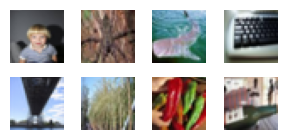

In [4]:
# Display image and label.
display_imgs,_ = next(iter(train_dataloader))
fig, axes = plt.subplots(2, 4, figsize=(3, 1.5))  # 可根据需要调整 figsize
axes = axes.flatten()
for i in range(8):
    img = display_imgs[i].permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')  # 关闭坐标轴
# 调整子图间距
plt.tight_layout()
plt.show()

In [5]:
import torch.nn as nn

class ToyModel(nn.Module):
    def __init__(self,time_emb_dim = 32):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim * 2)
        )
        
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        
        self.bottleneck = self.conv_block(256, 512)
        
        self.dec3 = self.conv_block(512 + 256, 256) 
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)
        self.time_emb_proj = nn.Linear(time_emb_dim * 2, 256)        
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def get_time_embedding(self, timestep, dim=32, max_period=10000):
        half = dim // 2
        freqs = torch.exp(-torch.arange(half, dtype=torch.float32) * torch.log(torch.tensor(max_period)) / half).to(timestep.device)
        args = timestep.unsqueeze(-1).float() * freqs.unsqueeze(0)  # (B, half)
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (B, dim)
        return embedding
    
    def forward(self, x,t):
        batch_size = x.shape[0]
        t_emb = self.get_time_embedding(t).to(x.device)  # (batch_size, time_emb_dim)
        t_emb = self.time_mlp(t_emb)  # (batch_size, time_emb_dim*2)
        e1 = self.enc1(x)         # (B, 64, 32, 32)
        e2 = self.enc2(self.pool(e1))  # (B, 128, 16, 16)
        e3 = self.enc3(self.pool(e2))  # (B, 256, 8, 8)
        b = self.bottleneck(self.pool(e3))  # (B, 512, 4, 4)
        time_emb = self.time_emb_proj(t_emb)  # (B, 256)
        time_emb = time_emb.view(batch_size, -1, 1, 1)  # (B, 256, 1, 1)
        e3 = e3 + time_emb  # 广播加法
        d3 = self.upsample(b)  # (B, 512, 8, 8)
        d3 = torch.cat([d3, e3], dim=1)  # (B, 512+256, 8, 8)
        d3 = self.dec3(d3)     # (B, 256, 8, 8)
        d2 = self.upsample(d3) # (B, 256, 16, 16)
        d2 = torch.cat([d2, e2], dim=1)  # (B, 256+128, 16, 16)
        d2 = self.dec2(d2)     # (B, 128, 16, 16)
        d1 = self.upsample(d2) # (B, 128, 32, 32)
        d1 = torch.cat([d1, e1], dim=1)  # (B, 128+64, 32, 32)
        d1 = self.dec1(d1)     # (B, 64, 32, 32)
        out = self.final_conv(d1)  # (B, 3, 32, 32)
        return out


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010970761009752916..0.9676626933108352].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17401659798050292..1.1205207336951717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.31809009553184814..1.2006961720730582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4070142279664972..1.282478755300074].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4698126849311134..1.6585982421180394].


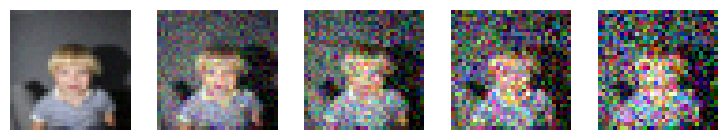

In [6]:
import numpy as np
# 
class Diffusion:
    def __init__(self,beta_start = 0.0001, beta_end = 0.02 , num_diffusion_timesteps = 1000):
        self.betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.num_timesteps = int(self.betas.shape[0])

    def add_noise(self,x,t):
        noise = torch.randn_like(x)
        sqrt_alphas_cumprod = torch.from_numpy(self.sqrt_alphas_cumprod[t])
        sqrt_one_minus_alphas_cumprod = torch.from_numpy(self.sqrt_one_minus_alphas_cumprod[t])
        noise_image = sqrt_alphas_cumprod.view(-1, 1, 1, 1) * x + sqrt_one_minus_alphas_cumprod.view(-1, 1, 1, 1) * noise
        return noise_image, noise

    def denoise(self,model,x,t):
        alpha= self.alphas[t]
        sqrt_alpha = np.sqrt(alpha)
        sqrt_one_minus_alpha_cumprod = self.sqrt_one_minus_alphas_cumprod[t]
        beta = self.betas[t]
        x = x.to(device)
        inpu_t = torch.full((x.shape[0],),t).to(device)
        pred_noise = model(x,inpu_t)
        x = (x-(1 -alpha)/sqrt_one_minus_alpha_cumprod*pred_noise)/sqrt_alpha
        if t > 0 :
            x = x + np.sqrt(beta)*torch.randn_like(x).to(device)
        return x
    
def show_add_noise(num_diffusion_timesteps = 5):
    diffusion = Diffusion(num_diffusion_timesteps =num_diffusion_timesteps)
    fig, axes = plt.subplots(nrows=1, ncols=num_diffusion_timesteps, figsize=(1.5*num_diffusion_timesteps, 1.5))
    axes = axes.flatten()
    to_add_noise_img = display_imgs[:1] # keep batch dim [1,3,32,32]
    for i in range(num_diffusion_timesteps):
        noise_img,_ = diffusion.add_noise(to_add_noise_img,[i])
        img = noise_img[0].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()   

show_add_noise()

In [7]:
from tqdm import tqdm
from IPython.display import clear_output
import os 

def train(model,diffusion,total_epoch,resume = False):
    
    model = model.to(device)
    if resume and os.path.exists('diffusion_toy_model_weights.pth'):
        model.load_state_dict(torch.load('diffusion_toy_model_weights.pth', weights_only=True))
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
    train_losses = []
    val_losses = []
    val_loss_at_step = []
    
    for epoch in range(total_epoch):
        model.train()
        for imgs,_ in tqdm(train_dataloader):
            t = torch.randint(0, diffusion.num_timesteps, (imgs.shape[0],))
            imgs,noise = diffusion.add_noise(imgs,t)
            imgs =imgs.to(torch.float32).to(device)
            noise =noise.to(device)
            output = model(imgs,t)
            loss = torch.mean((output-noise)**2,dim=[1,2,3]).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
        
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for imgs,_ in test_dataloader:
                t = torch.randint(0, diffusion.num_timesteps, (imgs.shape[0],))
                imgs,noise = diffusion.add_noise(imgs,t)
                imgs =imgs.to(torch.float32).to(device)
                noise =noise.to(device)
                output = model(imgs,t)
                loss = torch.mean((output-noise)**2,dim=[1,2,3]).mean()
                eval_loss.append(loss.item())
        val_losses.append(sum(eval_loss) / len(eval_loss))
        val_loss_at_step.append(len(train_losses) - 1)
        
        clear_output(wait=True)
        plt.figure(figsize=(6, 4))
        plt.plot(train_losses, label='Loss')
        plt.plot(val_loss_at_step,val_losses,label="val_loss")
        plt.title(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f} Val Loss: {val_losses[-1]:.4f}')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()    

In [8]:
model = ToyModel()
diffusion = Diffusion()

In [9]:
total_epoch = 20
train(model,diffusion,total_epoch,resume=True)
torch.save(model.state_dict(), 'diffusion_toy_model_weights.pth')

 10%|▉         | 153/1563 [00:04<00:38, 36.66it/s]


KeyboardInterrupt: 

100%|██████████| 1000/1000 [00:02<00:00, 365.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19733179..1.067262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03165787..1.1705052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07999095..1.0244834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051474806..0.9513273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06898058..1.1123344].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.26929006..1.1043348].
Clipping input data to the valid range for imshow with RGB data ([0..1] fo

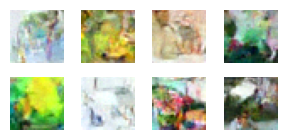

In [10]:
#denoise 
# torch.Size([32, 3, 32, 32]) torch.Size([32])
# torch.Size([32, 3, 32, 32]) torch.Size([32])
indices = list(range(1000))[::-1]
noise_img = torch.randn(8,3,32,32)
with torch.no_grad():
    model.eval()
    for t in tqdm(indices):
        noise_img = diffusion.denoise(model,noise_img,t)

fig, axes = plt.subplots(2, 4, figsize=(3, 1.5))  # 可根据需要调整 figsize
axes = axes.flatten()
for i in range(8):
    img = noise_img[i].permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].axis('off')  # 关闭坐标轴
# 调整子图间距
plt.tight_layout()
plt.show()